**EXP3 Predicitng Missing Cell-Types from Bulks using BayesPrism Residual**

*This file includes EXP3 results (details outlined in link below).*

Experimental Details: https://docs.google.com/spreadsheets/d/1fMV_URm95iPh-6rew-Be27I1-i8PNgGNWi2D_UO2V9w/edit#gid=0

Summary: Analyzing results form BayesPrism deconvolution done in EXP3_bayesprism.R.

*This file is intended to be run through Papermill in EXP2.py. See EXP3.py for details*

In [112]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

In [113]:
#####################
### set the study ###
#####################
#these parameters are set in papermill 
res_name = "MCT_adp_EXP3"
pseudos_name = "MCT_adp_EXP3"
path = "/../data/"
aug_data_path = "/../data/EXP3/"
data_path = "/../data/EXP3/BayesPrism/"
bp_path = "/../data/EXP3/BP_results/"
prop_type = "realistic"
noise_type = "nonoise"
num_missing_cells = [0,2]
nmf_cut = "minimum_value"
num_samples = 10000
random_seed = 88
bulk_type = f"{prop_type}prop_{noise_type}"

In [114]:
actual_path = os.getcwd()
path = f"{actual_path}{path}"
aug_data_path = f"{actual_path}{aug_data_path}"
data_path = f"{actual_path}{data_path}"
bp_path = f"{actual_path}{bp_path}"

Opening mixture file of pseudobulks and anndata for reference:

In [115]:
pseudo_path = os.path.join(data_path, f"{res_name}_{bulk_type}_mixture.csv")
pseudo_path = Path(pseudo_path)
# Open the CSV file of mixture used
pseudo_df = pd.read_csv(pseudo_path, sep=",")
#extracting gene_ids and setting as columns
pseudo_df.rename(columns = {'Unnamed: 0':'gene_ids'}, inplace = True)
gene_ids = pseudo_df["gene_ids"]
pseudo_df = pseudo_df.T
pseudo_df.columns = gene_ids
pseudo_df = pseudo_df.drop(labels = "gene_ids")
pseudo_df_copy = pseudo_df.copy()
pseudo_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
0,54.0,129.0,16.0,2119.0,122.0,37.0,696.0,15.0,156.0,6.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0
1,56.0,128.0,16.0,2985.0,139.0,56.0,679.0,15.0,249.0,6.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
2,56.0,115.0,13.0,2966.0,94.0,53.0,747.0,12.0,260.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,44.0,100.0,18.0,3364.0,114.0,66.0,806.0,16.0,222.0,9.0,...,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,3.0,0.0
4,59.0,127.0,13.0,2712.0,93.0,46.0,699.0,10.0,220.0,11.0,...,0.0,1.0,0.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,57.0,120.0,16.0,2365.0,85.0,54.0,720.0,12.0,259.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0
996,69.0,128.0,21.0,2261.0,66.0,54.0,748.0,19.0,216.0,5.0,...,0.0,0.0,0.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0
997,52.0,118.0,12.0,2606.0,107.0,53.0,753.0,19.0,181.0,5.0,...,1.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,4.0,1.0
998,42.0,112.0,9.0,2961.0,118.0,65.0,702.0,15.0,209.0,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [116]:
#and importing anndata object, with 2 missing
adata_path = os.path.join(data_path, f"{pseudos_name}_scadata_limitedcells_notlog.h5ad")
adata_path = Path(adata_path)
sc_adata = sc.read_h5ad(adata_path)
sc_adata_copy = sc_adata.copy()
sc_adata

AnnData object with n_obs × n_vars = 4462 × 26672
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'batch'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [117]:
#and importing anndata object with 0 missing
adata_path = os.path.join(aug_data_path, f"{pseudos_name}_snadata_limitedcells_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
sn_adata_copy = sn_adata.copy()
sn_adata

AnnData object with n_obs × n_vars = 11271 × 28242
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'batch'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [118]:
print(Counter(sc_adata.obs["cell_types"]))
# define the number of cells and the list of missing cell counts
num_cells = len(sc_adata.obs.cell_types.unique())
cell_order = sc_adata.obs.cell_types.unique()

Counter({'dendritic cell': 983, 'monocyte': 636, 'preadipocyte': 550, 'macrophage': 550, 'T cell': 550, 'endothelial cell': 542, 'immature NK T cell': 389, 'endothelial cell of lymphatic vessel': 157, 'mast cell': 53, 'pericyte cell': 52})


## **Reading In and QCing the BayesPrism Results:**

BayesPrism Results:

In [119]:
#import all BayesPrism results (through using InstaPrism) and real proportions
bp_prop = dict()
real_prop_reb = dict()
real_prop = dict()
ref_bp = dict()
gene_ids = dict()
for num in num_missing_cells:
    bp_results_path = os.path.join(bp_path, f"{res_name}_{num}missing_{bulk_type}_InstaPrism_results.csv")
    bp_results_path = Path(bp_results_path)
    # Open the CSV file in read mode
    bp_prop[num] = pd.read_csv(bp_results_path, sep="\t")
    bp_prop[num] = bp_prop[num].T
    #real proportions
num = 2   
realprop_results_path = os.path.join(aug_data_path, f"{res_name}_{num}missing_{bulk_type}_prop.csv")
realprop_results_path = Path(realprop_results_path)
# Open the CSV file in read mode
real_prop[num] = pd.read_csv(realprop_results_path, sep=",")

#real rebalanced proportions, we will delete the cell types
realrebprop_results_path = os.path.join(aug_data_path, f"{res_name}_{num}missing_{bulk_type}_prop.csv")
realrebprop_results_path = Path(realrebprop_results_path)
# Open the CSV file in read mode
real_prop_reb[num] = pd.read_csv(realrebprop_results_path, sep=",")
real_prop[2]

,mesothelial cell,fat cell,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,dendritic cell,mast cell,monocyte,immature NK T cell
0,0.271111,0.242931,0.118521,0.239495,0.018192,0.020718,0.003957,0.014857,0.001838,0.032553,0.020180,0.015646
1,0.230380,0.177024,0.096562,0.279433,0.110179,0.020464,0.007850,0.004998,0.004378,0.058810,0.003665,0.006257
2,0.286732,0.172803,0.061848,0.275625,0.154757,0.004968,0.002560,0.022390,0.006150,0.004275,0.000941,0.006951
3,0.151887,0.235572,0.166035,0.259285,0.115821,0.005894,0.015672,0.006133,0.008484,0.018908,0.011980,0.004328
4,0.251828,0.171549,0.201263,0.264474,0.060236,0.004264,0.013875,0.019275,0.002364,0.006548,0.001162,0.003163
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.252649,0.175555,0.108480,0.275674,0.057556,0.077842,0.005944,0.034932,0.004109,0.001269,0.001668,0.004321
996,0.260152,0.221408,0.084049,0.286275,0.042746,0.015784,0.052034,0.025628,0.007834,0.001175,0.002365,0.000550
997,0.276072,0.234815,0.106483,0.209433,0.081084,0.009403,0.020500,0.049767,0.001209,0.001988,0.007365,0.001881
998,0.199085,0.232102,0.156469,0.260605,0.092223,0.010561,0.001909,0.025492,0.000920,0.008269,0.004246,0.008121


In [120]:
#assigning the rest 
num = 2
#dropping cell types missing from proportions
real_prop_reb[num] = real_prop_reb[num].drop(['mesothelial cell','fat cell'], axis=1) 
for idx,sample in real_prop_reb[num].iterrows():
    tot = np.sum(sample) #making them equal 1
    sample = sample / tot
real_prop_reb[2]    

,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,dendritic cell,mast cell,monocyte,immature NK T cell
0,0.118521,0.239495,0.018192,0.020718,0.003957,0.014857,0.001838,0.032553,0.020180,0.015646
1,0.096562,0.279433,0.110179,0.020464,0.007850,0.004998,0.004378,0.058810,0.003665,0.006257
2,0.061848,0.275625,0.154757,0.004968,0.002560,0.022390,0.006150,0.004275,0.000941,0.006951
3,0.166035,0.259285,0.115821,0.005894,0.015672,0.006133,0.008484,0.018908,0.011980,0.004328
4,0.201263,0.264474,0.060236,0.004264,0.013875,0.019275,0.002364,0.006548,0.001162,0.003163
...,...,...,...,...,...,...,...,...,...,...
995,0.108480,0.275674,0.057556,0.077842,0.005944,0.034932,0.004109,0.001269,0.001668,0.004321
996,0.084049,0.286275,0.042746,0.015784,0.052034,0.025628,0.007834,0.001175,0.002365,0.000550
997,0.106483,0.209433,0.081084,0.009403,0.020500,0.049767,0.001209,0.001988,0.007365,0.001881
998,0.156469,0.260605,0.092223,0.010561,0.001909,0.025492,0.000920,0.008269,0.004246,0.008121


In [121]:
real_prop_reb[2].sum(axis=1)

0      0.485958
1      0.592596
2      0.540464
3      0.612541
4      0.576623
         ...   
995    0.571796
996    0.518440
997    0.489113
998    0.568813
999    0.418825
Length: 1000, dtype: float64

In [122]:
for idx, row in real_prop_reb[2].iterrows():
    prop = real_prop_reb[2].iloc[idx].values #extracting correct proportion
    total_prop = np.sum(prop)
    balanced_prop = prop / total_prop
    real_prop_reb[2].iloc[idx] = balanced_prop
real_prop_reb[0] = real_prop[2]

In [123]:
for num in num_missing_cells:
    #and the reference used in BP
    ref_results_path = os.path.join(bp_path, f"{res_name}_{num}missing_{bulk_type}_InstaPrism_usedref.csv")
    ref_results_path = Path(ref_results_path)
    # Open the CSV file in read mode
    ref_bp[num] = pd.read_csv(ref_results_path, sep="\t")
    #gene ids used for each
    gene_ids[num] = ref_bp[num].index
    #match columns and index
    bp_prop[num].columns =  real_prop_reb[num].columns
    bp_prop[num].index =  real_prop_reb[num].index

QC imported files:

In [124]:
real_prop[2] #there is no real proportion of 0 cells missing

,mesothelial cell,fat cell,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,dendritic cell,mast cell,monocyte,immature NK T cell
0,0.271111,0.242931,0.118521,0.239495,0.018192,0.020718,0.003957,0.014857,0.001838,0.032553,0.020180,0.015646
1,0.230380,0.177024,0.096562,0.279433,0.110179,0.020464,0.007850,0.004998,0.004378,0.058810,0.003665,0.006257
2,0.286732,0.172803,0.061848,0.275625,0.154757,0.004968,0.002560,0.022390,0.006150,0.004275,0.000941,0.006951
3,0.151887,0.235572,0.166035,0.259285,0.115821,0.005894,0.015672,0.006133,0.008484,0.018908,0.011980,0.004328
4,0.251828,0.171549,0.201263,0.264474,0.060236,0.004264,0.013875,0.019275,0.002364,0.006548,0.001162,0.003163
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.252649,0.175555,0.108480,0.275674,0.057556,0.077842,0.005944,0.034932,0.004109,0.001269,0.001668,0.004321
996,0.260152,0.221408,0.084049,0.286275,0.042746,0.015784,0.052034,0.025628,0.007834,0.001175,0.002365,0.000550
997,0.276072,0.234815,0.106483,0.209433,0.081084,0.009403,0.020500,0.049767,0.001209,0.001988,0.007365,0.001881
998,0.199085,0.232102,0.156469,0.260605,0.092223,0.010561,0.001909,0.025492,0.000920,0.008269,0.004246,0.008121


In [125]:
real_prop_reb[2] #but there is a rebalanced.

,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,dendritic cell,mast cell,monocyte,immature NK T cell
0,0.243892,0.492832,0.037436,0.042634,0.008143,0.030572,0.003782,0.066987,0.041527,0.032196
1,0.162947,0.471540,0.185926,0.034532,0.013246,0.008435,0.007388,0.099242,0.006185,0.010558
2,0.114435,0.509977,0.286340,0.009191,0.004737,0.041428,0.011379,0.007910,0.001741,0.012862
3,0.271060,0.423295,0.189083,0.009622,0.025585,0.010012,0.013851,0.030868,0.019559,0.007066
4,0.349037,0.458659,0.104464,0.007395,0.024062,0.033428,0.004099,0.011356,0.002015,0.005485
...,...,...,...,...,...,...,...,...,...,...
995,0.189719,0.482119,0.100658,0.136136,0.010396,0.061093,0.007186,0.002220,0.002917,0.007557
996,0.162119,0.552184,0.082451,0.030445,0.100367,0.049432,0.015111,0.002267,0.004562,0.001061
997,0.217707,0.428189,0.165778,0.019224,0.041912,0.101749,0.002472,0.004065,0.015058,0.003845
998,0.275079,0.458155,0.162132,0.018567,0.003357,0.044815,0.001617,0.014536,0.007464,0.014277


In [126]:
bp_prop[2] #bayes prism proportions with 2 missing

,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,dendritic cell,mast cell,monocyte,immature NK T cell
0,5.434722e-323,0.098150,0.553730,0.026881,3.795228e-03,5.379997e-247,0.068815,0.019945,0.214791,0.013893
1,5.434722e-323,0.078547,0.532851,0.024961,1.168698e-03,2.073286e-291,0.124053,0.011145,0.206706,0.020568
2,5.434722e-323,0.059122,0.543512,0.022079,3.215209e-42,3.971692e-234,0.151669,0.015272,0.203979,0.004366
3,4.940656e-323,0.111823,0.511676,0.013139,5.435749e-03,1.443253e-316,0.108961,0.010442,0.228918,0.009605
4,5.434722e-323,0.120510,0.531435,0.022857,1.169228e-02,2.493777e-279,0.091406,0.014338,0.199827,0.007935
...,...,...,...,...,...,...,...,...,...,...
995,5.434722e-323,0.081673,0.546818,0.047412,2.537698e-03,2.718538e-201,0.096961,0.016559,0.203068,0.004970
996,5.434722e-323,0.068648,0.587798,0.023903,4.890810e-04,8.786561e-198,0.075786,0.012681,0.226204,0.004491
997,5.434722e-323,0.085938,0.529794,0.023343,2.128992e-03,1.576355e-118,0.106209,0.022037,0.224741,0.005809
998,5.434722e-323,0.102940,0.531596,0.018253,5.815500e-03,1.279934e-217,0.096972,0.018394,0.218964,0.007066


In [127]:
#The BayesPrism reference should sum to 1 for each cell type expression
ref_bp[2].sum(axis =0)

dendritic cell                          1.0
monocyte                                1.0
preadipocyte                            1.0
endothelial cell of lymphatic vessel    1.0
macrophage                              1.0
T cell                                  1.0
endothelial cell                        1.0
immature NK T cell                      1.0
pericyte cell                           1.0
mast cell                               1.0
dtype: float64

In [128]:
#cutting to genes used in each one
pseudo_df = dict()
sn_adata = dict()
ref_df = dict()
for num in num_missing_cells:
    pseudo_df[num] = pseudo_df_copy[gene_ids[num]]
    sn_adata[num] = sn_adata_copy[:, gene_ids[num]]

Visualize BayesPrism proportions:

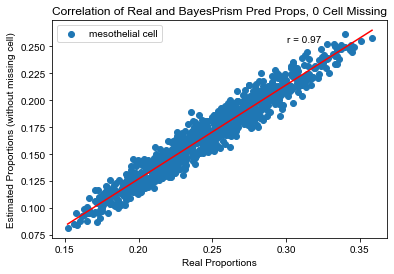

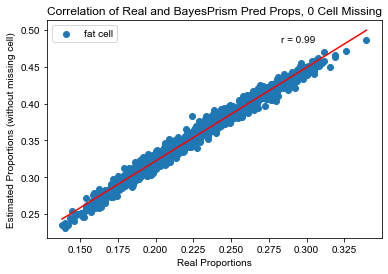

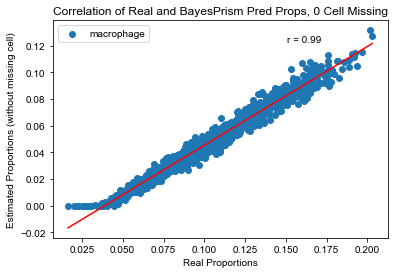

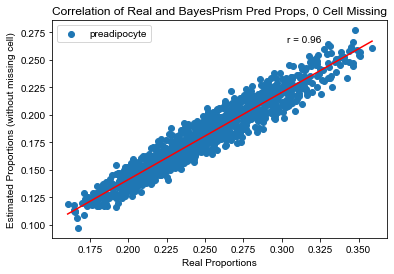

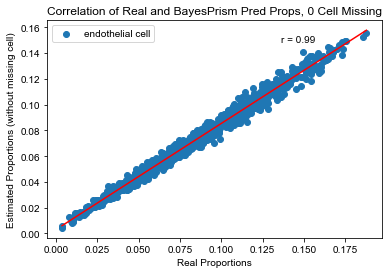

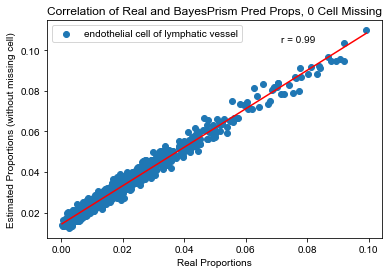

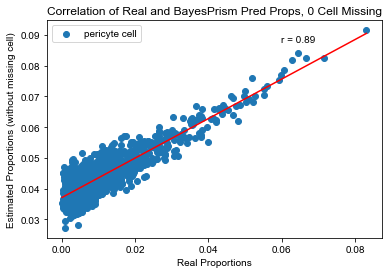

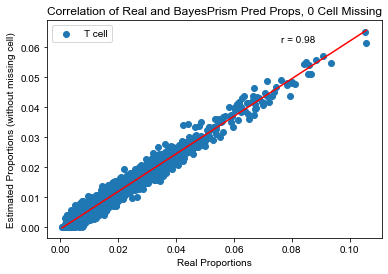

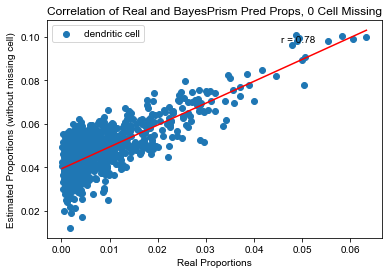

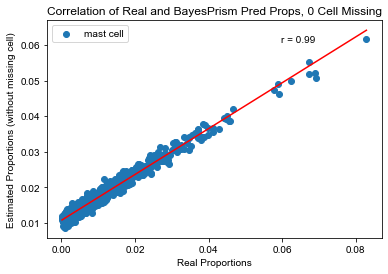

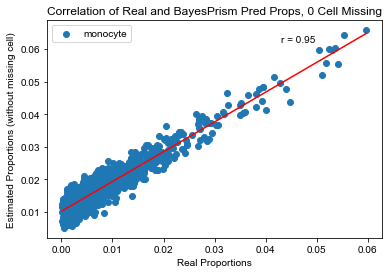

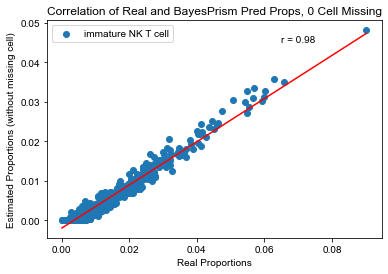

In [129]:
#Evaluation performance with no cell types missing, expect to be very close to 1.
num = 0
for col_cell in real_prop_reb[num].columns:
    x = real_prop_reb[num][col_cell].values.astype(float)
    y = bp_prop[num][col_cell].values.astype(float)
    correlation_coefficient = np.corrcoef(x, y)[0,1]
    plt.scatter(x, y, label= f"{col_cell}")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = "red")
    r, p = stats.pearsonr(x, y)
    plt.annotate('r = {:.2f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and BayesPrism Pred Props, {num} Cell Missing')
    plt.legend()
    plt.show()

Real Proportions shape: (1000, 12)
Estimated Proportions shape: (1000, 12)


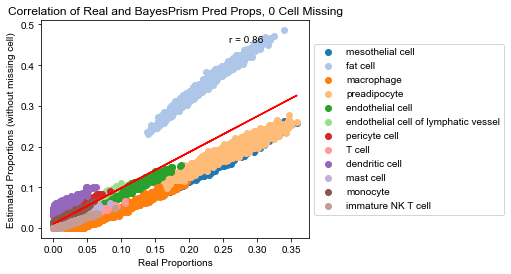

Real Proportions shape: (1000, 10)
Estimated Proportions shape: (1000, 10)


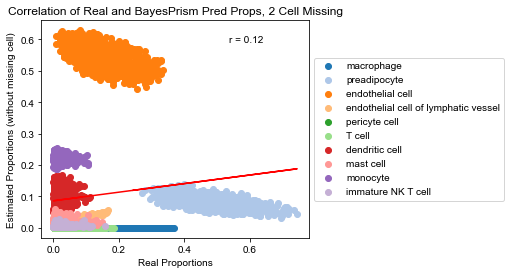

In [130]:
#Comparnig performance for all cell types with num_cells_missing.
# define colormap for coloring cell types
cmap = get_cmap('tab20') 
for num in num_missing_cells:
    real_proportions = real_prop_reb[num].values.astype(float) #real proportions of present cells
    estimated_proportions = bp_prop[num].values.astype(float) #estimated proportions of present cells.
    cell_types = real_prop_reb[num].columns.tolist() 
    # Print the shapes of the matrices
    print("Real Proportions shape:", real_proportions.shape)
    print("Estimated Proportions shape:", estimated_proportions.shape)
    correlation_coefficient = np.corrcoef(real_proportions, estimated_proportions)[0, 1]
    #scatter plot with colored points for each cell type
    fig, ax = plt.subplots()
    for i, cell_type in enumerate(cell_types):
        x = real_proportions[:, i]
        y = estimated_proportions[:, i]
        color = cmap(i)  #unique color for each cell type
        ax.scatter(x, y, label=cell_type, color=color)
    #fit a regression line
    m, b = np.polyfit(real_proportions.flatten(), estimated_proportions.flatten(), 1)
    plt.plot(real_proportions.flatten(), m * real_proportions.flatten() + b, color="red")
    r, p = stats.pearsonr(real_proportions.flatten(), estimated_proportions.flatten())
    plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and BayesPrism Pred Props, {num} Cell Missing')
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    plt.show()

In [131]:
#the difference between calculated and real proportions.
custom_res_tot = dict()
for num in num_missing_cells:
    custom_res_tot[num] = real_prop_reb[num].values - bp_prop[num]

## **Extracting Missing Cell Information:**

In [132]:
cells_to_miss = dict()
missing_cell_tot  = dict()
num = 2
#cells that are missing
cells_to_miss[num] = np.setdiff1d(real_prop[2].columns, ref_bp[num].columns)
#extracting real proportions from missing cells
missing_cell_tot[num] = real_prop[2][cells_to_miss[num]]
print(f"{num} missing: {missing_cell_tot[num].shape}")

2 missing: (1000, 2)


In [133]:
#recreate matrix with calculated proportion BayesPrism and multiplying by the used reference
recreated_mat_all = dict()
for num in num_missing_cells:
        recreated_mat_all[num] = pd.DataFrame(ref_bp[num] @ bp_prop[num].T)
        recreated_mat_all[num] = recreated_mat_all[num].T
        recreated_mat_all[num].columns = gene_ids[num]
recreated_mat_all[0]   

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AC024257.5,LINC01243,OR2Z1,TNK2-AS1,AC007991.4,AC010907.2,OR2B11,AC105924.1,AC239803.3,HIST1H3G
0,0.000005,0.000011,0.000001,0.000209,0.000010,0.000006,0.000067,6.667387e-07,0.000012,8.043285e-07,...,3.044902e-08,3.076327e-08,1.316018e-08,5.089804e-08,3.044902e-08,1.316018e-08,2.377440e-08,3.044902e-08,2.377440e-08,6.467244e-08
1,0.000005,0.000011,0.000001,0.000282,0.000013,0.000006,0.000064,8.187776e-07,0.000015,9.730332e-07,...,2.894025e-08,4.302308e-08,1.058894e-08,4.788050e-08,2.894025e-08,1.058894e-08,1.797544e-08,2.894025e-08,1.797544e-08,5.585595e-08
2,0.000005,0.000011,0.000001,0.000272,0.000009,0.000005,0.000065,9.021966e-07,0.000015,9.866118e-07,...,2.983334e-08,1.899102e-08,1.118732e-08,4.966669e-08,2.983334e-08,1.118732e-08,1.440388e-08,2.983334e-08,1.440388e-08,5.407057e-08
3,0.000004,0.000009,0.000001,0.000276,0.000010,0.000006,0.000066,7.572792e-07,0.000013,8.690179e-07,...,3.774599e-08,2.594342e-08,1.000157e-08,6.549198e-08,3.774599e-08,1.000157e-08,2.166930e-08,3.774599e-08,2.166930e-08,7.716127e-08
4,0.000005,0.000011,0.000001,0.000250,0.000008,0.000006,0.000062,8.071011e-07,0.000013,9.190814e-07,...,3.594574e-08,2.076894e-08,1.000000e-08,6.189148e-08,3.594574e-08,1.000000e-08,1.838464e-08,3.594574e-08,1.838464e-08,7.027612e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000005,0.000011,0.000001,0.000223,0.000008,0.000006,0.000064,7.910335e-07,0.000016,9.791277e-07,...,2.958821e-08,1.741668e-08,1.006308e-08,4.917641e-08,2.958821e-08,1.006308e-08,1.609418e-08,2.958821e-08,1.609418e-08,5.527059e-08
996,0.000005,0.000011,0.000001,0.000217,0.000008,0.000006,0.000067,8.074588e-07,0.000014,1.006040e-06,...,2.868376e-08,1.733911e-08,1.000000e-08,4.736751e-08,2.868376e-08,1.000000e-08,1.594300e-08,2.868376e-08,1.594300e-08,5.331051e-08
997,0.000004,0.000010,0.000001,0.000238,0.000009,0.000006,0.000067,7.550473e-07,0.000013,7.283611e-07,...,2.958222e-08,1.815430e-08,1.000000e-08,4.916445e-08,2.958222e-08,1.000000e-08,1.755721e-08,2.958222e-08,1.755721e-08,5.672166e-08
998,0.000004,0.000010,0.000001,0.000253,0.000010,0.000006,0.000066,7.383165e-07,0.000013,8.945298e-07,...,3.381174e-08,2.141974e-08,1.125274e-08,5.762347e-08,3.381174e-08,1.125274e-08,1.854778e-08,3.381174e-08,1.854778e-08,6.617125e-08


In [134]:
# Get the corresponding missing_cell_proportions
missing_cell_prop = dict()
missing_cell_prop[0] = []
missing_cell_prop[2] = real_prop[2][missing_cell_tot[num].columns]  
print(f"{num} missing: prop is {missing_cell_prop[num].shape}")

2 missing: prop is (1000, 2)


## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (ref_bp) * calculated proportions (calc_prop_tot))

First normalizing the pseudobulks:

In [135]:
norm_pseudo_df = dict()
for num in num_missing_cells:
    #clippign before scaling to 95th pecentile
    pseudo_copy = pseudo_df[num].copy() #keeping genes
    pseudo = pseudo_copy.values #np array
    clip_upper = np.quantile(pseudo, 0.95)
    pseudo = np.clip(pseudo, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo)
    normalized_pseudo_df = scaler.transform(pseudo)
    normalized_pseudo_df = pd.DataFrame(normalized_pseudo_df, 
                                columns = pseudo_copy.columns, index= pseudo_copy.index)
    norm_pseudo_df[num] = normalized_pseudo_df     

In [136]:
#Residual as the the difference between the recreated matrix and pseudobulks.
residuals = dict()
for num in num_missing_cells:
    res = pseudo_df[num].values - recreated_mat_all[num].values
    residuals[num] = pd.DataFrame(res, columns = gene_ids[num])
residuals[0]    

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AC024257.5,LINC01243,OR2Z1,TNK2-AS1,AC007991.4,AC010907.2,OR2B11,AC105924.1,AC239803.3,HIST1H3G
0,53.999995,128.999989,15.999999,2118.999791,121.99999,36.999994,695.999933,14.999999,155.999988,5.999999,...,-0.0,-0.0,-0.0,2.0,-0.0,-0.0,-0.0,3.0,-0.0,-0.0
1,55.999995,127.999989,15.999999,2984.999718,138.999987,55.999994,678.999936,14.999999,248.999985,5.999999,...,1.0,-0.0,-0.0,-0.0,1.0,1.0,1.0,1.0,-0.0,1.0
2,55.999995,114.999989,12.999999,2965.999728,93.999991,52.999995,746.999935,11.999999,259.999985,7.999999,...,2.0,-0.0,2.0,-0.0,-0.0,2.0,1.0,-0.0,-0.0,-0.0
3,43.999996,99.999991,17.999999,3363.999724,113.99999,65.999994,805.999934,15.999999,221.999987,8.999999,...,2.0,-0.0,-0.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0
4,58.999995,126.999989,12.999999,2711.99975,92.999992,45.999994,698.999938,9.999999,219.999987,10.999999,...,1.0,1.0,-0.0,1.0,1.0,1.0,-0.0,3.0,1.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,56.999995,119.999989,15.999999,2364.999777,84.999992,53.999994,719.999936,11.999999,258.999984,5.999999,...,-0.0,1.0,-0.0,-0.0,1.0,1.0,-0.0,1.0,-0.0,1.0
996,68.999995,127.999989,20.999999,2260.999783,65.999992,53.999994,747.999933,18.999999,215.999986,4.999999,...,2.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,3.0,-0.0,1.0
997,51.999996,117.99999,11.999999,2605.999762,106.999991,52.999994,752.999933,18.999999,180.999987,4.999999,...,-0.0,-0.0,-0.0,4.0,-0.0,-0.0,-0.0,2.0,1.0,1.0
998,41.999996,111.99999,8.999999,2960.999747,117.99999,64.999994,701.999934,14.999999,208.999987,4.999999,...,1.0,1.0,1.0,-0.0,1.0,1.0,-0.0,-0.0,-0.0,-0.0


In [137]:
ref_bp_scaled = dict()
pseudo_scaled = dict()
for num in num_missing_cells:
    #clippign before scaling to 95th pecentile
    ref_raw_val = ref_bp[num].values ##reference of bayes prism
    clip_upper = np.quantile(ref_raw_val, 0.90)
    ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
    #and scaling to be between values 0 and 1 
    scaler = MinMaxScaler()
    scaler.fit(ref_raw_val)
    ref_scale = scaler.transform(ref_raw_val)
    ref_bp_scaled[num] = pd.DataFrame(ref_scale, index = gene_ids[num], 
                                columns = real_prop_reb[num].columns)

    #clippign before scaling to 95th pecentile
    pseudo_raw_val = pseudo_df[num][ref_bp[num].index].values ##pseudobulks
    clip_upper = np.quantile(pseudo_raw_val, 0.90)
    pseudo_raw_val = np.clip(pseudo_raw_val, 0, clip_upper)
    #and scaling to be between values 0 and 1 
    scaler = MinMaxScaler()
    scaler.fit(pseudo_raw_val)
    pseudo_scale = scaler.transform(pseudo_raw_val)
    pseudo_scaled[num] = pd.DataFrame(pseudo_scale, columns = gene_ids[num])

In [138]:
print(ref_bp[2].max().max())
print(ref_bp_scaled[2].max().max())

0.0240338823842394
1.0


In [139]:
print(pseudo_df[2].max().max())
print(pseudo_scaled[2].max().max())

119060.0
1.0000000000000036


In [140]:
#Residual with the scaled pseudobulk and scaled bayes prism reference
residuals_scaled = dict()
for num in num_missing_cells:
    res = (pseudo_scaled[num].values)  - (bp_prop[num] @ ref_bp_scaled[num].T)
    residuals_scaled[num] = pd.DataFrame(res, columns = gene_ids[num])
residuals_scaled[0]    

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AC024257.5,LINC01243,OR2Z1,TNK2-AS1,AC007991.4,AC010907.2,OR2B11,AC105924.1,AC239803.3,HIST1H3G
0,0.466040,0.472939,0.414666,0.005645,0.369555,0.029163,-0.359519,0.349854,-0.050296,0.254342,...,-0.000227,-0.000230,-3.507205e-05,0.399546,-0.000227,-3.507205e-05,-0.000153,0.428344,-0.000153,-0.000607
1,0.497955,0.461176,0.416090,0.003269,0.480225,0.341422,-0.392207,0.348167,0.544024,0.252470,...,0.249790,-0.000366,-6.536067e-06,-0.000420,0.249790,1.999935e-01,0.333245,0.142647,-0.000089,0.249491
2,0.497282,0.318759,0.308819,0.001805,0.159381,0.294210,-0.199728,0.240098,0.612986,0.357583,...,0.499780,-0.000100,6.666535e-01,-0.000440,-0.000220,3.999868e-01,0.333284,-0.000220,-0.000049,-0.000489
3,0.307680,0.174396,0.486081,0.004783,0.308004,0.493158,-0.018971,0.384564,0.377706,0.411519,...,0.499692,-0.000177,-1.741077e-08,0.399384,0.499692,4.000000e-01,0.333204,0.142549,0.399870,0.249255
4,0.546728,0.446795,0.309050,0.003436,0.164934,0.178627,-0.313057,0.169725,0.374348,0.516227,...,0.249712,0.199880,-4.324694e-23,0.199424,0.249712,2.000000e-01,-0.000093,0.428283,0.199907,-0.000669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.513472,0.372826,0.415672,0.002498,0.101228,0.309782,-0.259823,0.241332,0.600101,0.252402,...,-0.000217,0.199918,-7.000421e-07,-0.000435,0.249783,1.999993e-01,-0.000068,0.142640,-0.000068,0.249498
996,0.712565,0.462410,0.593091,0.002436,-0.038786,0.303515,-0.207212,0.491150,0.332900,0.199472,...,0.499793,-0.000081,-9.924940e-50,-0.000415,-0.000207,-9.924940e-50,-0.000066,0.428364,-0.000066,0.249519
997,0.433566,0.356505,0.271902,0.003097,0.256564,0.288522,-0.191933,0.491731,0.110675,0.202554,...,-0.000217,-0.000090,-2.005092e-18,0.799565,-0.000217,-2.005092e-18,-0.000084,0.285497,0.199916,0.249481
998,0.270317,0.298644,0.164667,0.003503,0.339631,0.479171,-0.336683,0.349060,0.293533,0.200710,...,0.249736,0.199873,3.333194e-01,-0.000529,0.249736,1.999861e-01,-0.000095,-0.000264,-0.000095,-0.000623


## NMF

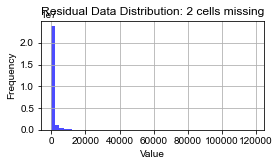

In [141]:
#distribution of residuals
data = residuals[num].values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

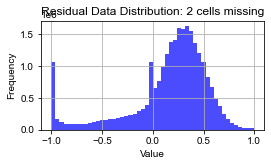

In [142]:
#distribution of residuals
data = residuals_scaled[num].values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Shifting distributions according to above plots, and calculating NMF:

1.0000000000000016


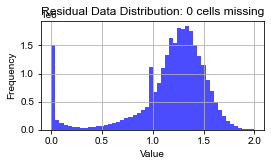

1.000000000000001


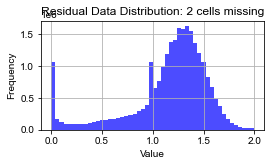

In [143]:
#shift_scaleding distribution of residuals to do NMF
residuals_shift = residuals
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift_scaled distributions minimally:
        min_val = abs(np.min(np.min(residuals_scaled[num])))
        print(min_val)
        residuals_shift[num] = residuals_scaled[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift[num][residuals_shift[num].values <= 0] = 0
    data = residuals_shift[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

1.0000000000000016


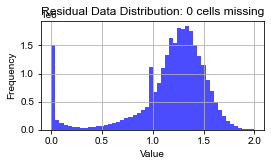

1.000000000000001


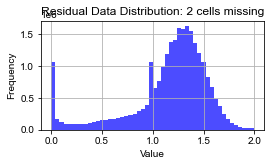

In [144]:
#shift_scaleding distribution of residuals to do NMF
residuals_shift_scaled = residuals_scaled
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift_scaled distributions minimally:
        min_val = abs(np.min(np.min(residuals_scaled[num])))
        print(min_val)
        residuals_shift_scaled[num] = residuals_scaled[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift_scaled[num][residuals_shift_scaled[num].values <= 0] = 0
    data = residuals_shift_scaled[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Residual

In [145]:
num_missing_cells= [2]

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


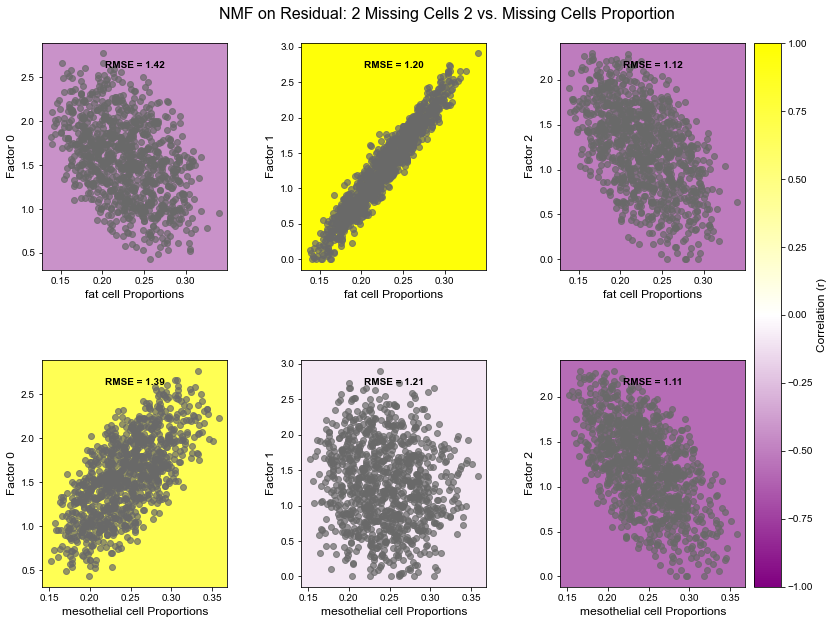

In [146]:
#NMF Residual(by sample) compared to each missing celltype proportion
#nmf on residual 1
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = 3
    nmf = NMF(n_components = num_nmf, max_iter=10000, init="nndsvd")
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
    vp.factors_vs_proportions_heatmaps_real(res_nmf, missing_cell_prop, 2, method = "NMF")
    #It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

Residual_scaled

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


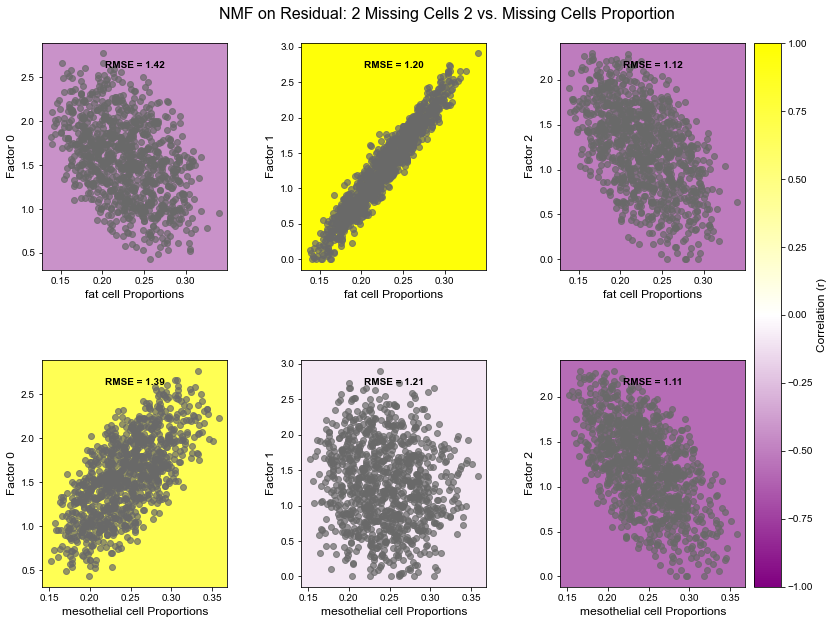

In [147]:
#NMF Residual(by sample) compared to each missing celltype proportion
#nmf on residual 1
res_nmf = dict()

for num in num_missing_cells:
    num_nmf = 3
    nmf = NMF(n_components = num_nmf, max_iter=10000, init="nndsvd")
    res_nmf_df = nmf.fit_transform(residuals_shift_scaled[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
    vp.factors_vs_proportions_heatmaps_real(res_nmf, missing_cell_prop, 2, method = "NMF")
    #It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 